## Import

In [23]:
import jax
import jax.numpy as jnp
from cax.models.lenia import (
	FreeKernelParams,
	GrowthParams,
	OriginalKernelParams,
	RuleParams,
	free_kernel_fn,
	original_kernel_fn,
)
from flax import nnx

## Configuration

In [24]:
num_dims = 2
state_size = 128

R = 12
T = 2

state_scale = 1

In [13]:
import matplotlib.pyplot as plt

seed = 0

config = {
	"state_size": 128,
	"channel_size": 3,
	"R": 12,
	"T": 2,
	"state_scale": 1,
	"kernel_params": [
		{"b": [1], "m": 0.272, "s": 0.0595, "h": 0.138, "r": 0.91, "c0": 0, "c1": 0},
		{"b": [1], "m": 0.349, "s": 0.1585, "h": 0.48, "r": 0.62, "c0": 0, "c1": 0},
		{"b": [1, 1 / 4], "m": 0.2, "s": 0.0332, "h": 0.284, "r": 0.5, "c0": 0, "c1": 0},
		{"b": [0, 1], "m": 0.114, "s": 0.0528, "h": 0.256, "r": 0.97, "c0": 1, "c1": 1},
		{"b": [1], "m": 0.447, "s": 0.0777, "h": 0.5, "r": 0.72, "c0": 1, "c1": 1},
		{"b": [5 / 6, 1], "m": 0.247, "s": 0.0342, "h": 0.622, "r": 0.8, "c0": 1, "c1": 1},
		{"b": [1], "m": 0.21, "s": 0.0617, "h": 0.35, "r": 0.96, "c0": 2, "c1": 2},
		{"b": [1], "m": 0.462, "s": 0.1192, "h": 0.218, "r": 0.56, "c0": 2, "c1": 2},
		{"b": [1], "m": 0.446, "s": 0.1793, "h": 0.556, "r": 0.78, "c0": 2, "c1": 2},
		{"b": [11 / 12, 1], "m": 0.327, "s": 0.1408, "h": 0.344, "r": 0.79, "c0": 0, "c1": 1},
		{"b": [3 / 4, 1], "m": 0.476, "s": 0.0995, "h": 0.456, "r": 0.5, "c0": 0, "c1": 2},
		{"b": [11 / 12, 1], "m": 0.379, "s": 0.0697, "h": 0.67, "r": 0.72, "c0": 1, "c1": 0},
		{"b": [1], "m": 0.262, "s": 0.0877, "h": 0.42, "r": 0.68, "c0": 1, "c1": 2},
		{"b": [1 / 6, 1, 0], "m": 0.412, "s": 0.1101, "h": 0.43, "r": 0.82, "c0": 2, "c1": 0},
		{"b": [1], "m": 0.201, "s": 0.0786, "h": 0.278, "r": 0.82, "c0": 2, "c1": 1},
	],
}

num_steps = 128

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

In [14]:
def init_state(pattern):
	pattern = jnp.transpose(pattern, axes=(1, 2, 0))

	state_size, channel_size, state_scale = (
		128,
		3,
		1,
	)
	mid = state_size // 2

	# Scale cells
	scaled_cells = pattern.repeat(state_scale, axis=-3).repeat(state_scale, axis=-2)
	cx, cy = scaled_cells.shape[0], scaled_cells.shape[1]

	# Create empty state and place cells
	state = jnp.zeros((state_size, state_size, channel_size))
	state = state.at[mid - cx // 2 : mid + cx - cx // 2, mid - cy // 2 : mid + cy - cy // 2, :].set(
		scaled_cells
	)
	return state

In [15]:
# fmt: off
patterns = {
	"VT049W": jnp.asarray([
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.49, 1.0, 0, 0.03, 0.49, 0.49, 0.28, 0.16, 0.03, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0.47, 0.31, 0.58, 0.51, 0.35, 0.28, 0.22, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.15, 0.32, 0.17, 0.61, 0.97, 0.29, 0.67, 0.59, 0.88, 1.0, 0.92, 0.8, 0.61, 0.42, 0.19, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.25, 0.64, 0.26, 0.92, 0.04, 0.24, 0.97, 1.0, 1.0, 1.0, 1.0, 0.97, 0.71, 0.33, 0.12, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.38, 0.84, 0.99, 0.78, 0.67, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.62, 0.37, 0, 0], [0, 0, 0, 0, 0.04, 0.11, 0, 0.69, 0.75, 0.75, 0.91, 1.0, 1.0, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.81, 0.42, 0.07, 0], [0, 0, 0, 0, 0.44, 0.63, 0.04, 0, 0, 0, 0.11, 0.14, 0, 0.05, 0.64, 1.0, 1.0, 1.0, 1.0, 1.0, 0.92, 0.56, 0.23, 0], [0, 0, 0, 0, 0.11, 0.36, 0.35, 0.2, 0, 0, 0, 0, 0, 0, 0.63, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.49, 0.26, 0], [0, 0, 0, 0, 0, 0.4, 0.37, 0.18, 0, 0, 0, 0, 0, 0.04, 0.41, 0.52, 0.67, 0.82, 1.0, 1.0, 0.91, 0.4, 0.23, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0, 0.05, 0.45, 0.89, 1.0, 0.66, 0.35, 0.09, 0], [0, 0, 0.22, 0, 0, 0, 0.05, 0.36, 0.6, 0.13, 0.02, 0.04, 0.24, 0.34, 0.1, 0, 0.04, 0.62, 1.0, 1.0, 0.44, 0.25, 0, 0], [0, 0, 0, 0.43, 0.53, 0.58, 0.78, 0.9, 0.96, 1.0, 1.0, 1.0, 1.0, 0.71, 0.46, 0.51, 0.81, 1.0, 1.0, 0.93, 0.19, 0.06, 0, 0], [0, 0, 0, 0, 0.23, 0.26, 0.37, 0.51, 0.71, 0.89, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42, 0.06, 0, 0, 0], [0, 0, 0, 0, 0.03, 0, 0, 0.11, 0.35, 0.62, 0.81, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 0.64, 0.15, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.06, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.05, 0.09, 0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.28, 0.42, 0.44, 0.34, 0.18, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.34, 1.0, 1.0, 1.0, 1.0, 1.0, 0.91, 0.52, 0.14, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.17, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.35, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.22, 0.92, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.59, 0.09], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.71, 0.16], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.01, 0.67, 0.83, 0.85, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.68, 0.17], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.21, 0.04, 0.12, 0.58, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.57, 0.13], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0, 0, 0, 0.2, 0.64, 0.96, 1.0, 1.0, 1.0, 0.9, 0.24, 0.01], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.29, 0, 0, 0, 0.25, 0.9, 1.0, 1.0, 1.0, 1.0, 0.45, 0.05, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.31, 0.07, 0, 0.46, 0.96, 1.0, 1.0, 1.0, 1.0, 0.51, 0.12, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.26, 0.82, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.28, 0.74, 1.0, 0.95, 0.87, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.07, 0.69, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 0.25, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0.72, 0.9, 0.83, 0.7, 0.56, 0.43, 0.14, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.25, 0.37, 0.44, 0.37, 0.24, 0.11, 0.04, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.19, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.4, 0.15, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.14, 0.48, 0.83, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.62, 0.78, 0.94, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.64, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.02, 0.65, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.78, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.15, 0.48, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.79, 0.05, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.33, 0.56, 0.8, 1.0, 1.0, 1.0, 0.37, 0.6, 0.94, 1.0, 1.0, 1.0, 1.0, 0.68, 0.05, 0, 0, 0], [0, 0, 0, 0, 0.35, 0.51, 0.76, 0.89, 1.0, 1.0, 0.72, 0.15, 0, 0.29, 0.57, 0.69, 0.86, 1.0, 0.92, 0.49, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.38, 0.86, 1.0, 1.0, 0.96, 0.31, 0, 0, 0, 0, 0.02, 0.2, 0.52, 0.37, 0.11, 0, 0, 0, 0], [0, 0, 0.01, 0, 0, 0.07, 0.75, 1.0, 1.0, 1.0, 0.48, 0.03, 0, 0, 0, 0, 0, 0.18, 0.07, 0, 0, 0, 0, 0], [0, 0.11, 0.09, 0.22, 0.15, 0.32, 0.71, 0.94, 1.0, 1.0, 0.97, 0.54, 0.12, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.06, 0.33, 0.47, 0.51, 0.58, 0.77, 0.95, 1.0, 1.0, 1.0, 1.0, 0.62, 0.12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.04, 0.4, 0.69, 0.88, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.68, 0.22, 0.02, 0, 0, 0.01, 0, 0, 0, 0, 0, 0, 0], [0, 0.39, 0.69, 0.91, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85, 0.52, 0.35, 0.24, 0.17, 0.07, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 0.82, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.67, 0.29, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.2, 0.51, 0.77, 0.96, 0.93, 0.71, 0.4, 0.16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.08, 0.07, 0.03, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
	]),
	"5N7KKM": jnp.asarray([
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.12, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.49, 0, 0, 0, 0, 0, 0, 0.23, 0.47, 0.31, 0.93, 0.75, 0, 0, 0, 0], [0, 0, 0, 0.23, 0, 0, 0.65, 0.68, 0.12, 0, 0, 0, 0.02, 0.40, 0.82, 0.86, 0, 0.19, 0, 0], [0, 0, 0.01, 0.01, 0.77, 1.00, 0.98, 1.00, 0.97, 0.85, 0.70, 0.55, 0.12, 0.15, 0.01, 0, 0, 0.95, 0, 0], [0, 0, 0, 0.66, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.74, 0.76, 0.27, 0, 0, 0.18, 0.59, 0.31, 0], [0, 0.04, 0.08, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.68, 0.07, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 1.00, 1.00, 1.00, 1.00, 0.90, 1.00, 0.92, 0.58, 0.84, 0.89, 0.39, 0, 0, 0.04, 1.00, 0, 0], [0, 0.06, 0.27, 1.00, 1.00, 1.00, 0.82, 0.39, 0, 0, 0, 0.12, 0.87, 0.70, 0.58, 0.04, 0.40, 1.00, 0.35, 0], [0, 0.21, 0.38, 1.00, 1.00, 0.66, 0, 0, 0, 0, 0, 0, 1.00, 0.79, 0.74, 0.16, 0.31, 0.42, 0, 0], [0, 0.26, 0.50, 1.00, 1.00, 0.46, 0, 0, 0, 0, 0, 0.40, 1.00, 1.00, 0.71, 0.16, 0, 0.22, 0, 0], [0, 0.14, 0.48, 1.00, 1.00, 0.77, 0, 0, 0, 0, 0, 1.00, 1.00, 1.00, 0.79, 0, 0, 0, 0, 0], [0, 0, 0.16, 1.00, 1.00, 1.00, 0.19, 0, 0, 0.09, 0.20, 0.57, 1.00, 1.00, 0.74, 0, 0, 0, 0, 0], [0, 0, 0, 0.59, 1.00, 1.00, 0.85, 0.75, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.47, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.95, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.96, 0.44, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.25, 0.79, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.96, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.04, 0.06, 0.26, 0.61, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0, 0.32, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.15, 0, 0.02, 0.23, 0.24, 0.05, 0, 0, 0.25, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.04, 0, 0, 0.08, 0, 0, 0, 0, 0, 0, 0]],  # noqa
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.03, 0.43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.14, 0.47, 0, 0, 0.27, 0.92, 0.87, 0.70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.86, 1.00, 0.66, 1.00, 1.00, 1.00, 1.00, 0.33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 0.13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0.22, 0.30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.76, 1.00, 1.00, 1.00, 1.00, 1.00, 0.83, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.71, 1.00, 1.00, 1.00, 1.00, 0.77, 0.81, 0.75, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.69, 1.00, 1.00, 1.00, 0.88, 0.24, 0.35, 0.62, 0.35, 0.09, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.29, 1.00, 1.00, 1.00, 0.98, 0.38, 0.13, 0.65, 0.88, 0.32, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.09, 1.00, 1.00, 1.00, 0.93, 0.77, 0.88, 0.24, 0.03, 0.69, 1.00, 0.78, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.44, 1.00, 1.00, 1.00, 1.00, 1.00, 0.76, 0.83, 1.00, 0.92, 0.17, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.36, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.12, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.06, 0.39, 0.79, 1.00, 1.00, 1.00, 0.48, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.16, 0.59, 1.00, 1.00, 1.00, 0.13, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.16, 0.02, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
		[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.51, 0.46, 0.26, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.38, 1.00, 1.00, 0.96, 0.85, 0.57, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.06, 0.63, 1.00, 1.00, 1.00, 1.00, 0.96, 0.70, 0.08, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.01, 0.36, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.82, 0.49, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.05, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 0.65, 0.04, 0, 0, 0, 0], [0, 0, 0.01, 0, 0.08, 0.52, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.93, 0, 0, 0, 0, 0], [0, 0, 0.03, 0, 0.09, 0.49, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.58, 0.04, 0, 0, 0, 0, 0], [0, 0, 0.02, 0, 0.08, 0.50, 1.00, 1.00, 1.00, 1.00, 1.00, 0.81, 0, 0, 0, 0, 0.08, 0.01, 0, 0], [0, 0, 0, 0, 0.04, 0.47, 1.00, 1.00, 1.00, 1.00, 0.40, 0, 0, 0, 0, 0.77, 0.85, 0.35, 0, 0], [0, 0, 0, 0, 0.03, 0.41, 1.00, 1.00, 1.00, 1.00, 0.20, 0, 0, 0.01, 1.00, 1.00, 1.00, 0.55, 0, 0], [0, 0, 0, 0, 0, 0.30, 0.98, 1.00, 1.00, 1.00, 0.68, 0.09, 0.26, 1.00, 1.00, 1.00, 1.00, 0.70, 0.19, 0], [0, 0, 0, 0, 0, 0.13, 0.55, 0.95, 1.00, 1.00, 1.00, 0.89, 1.00, 1.00, 1.00, 1.00, 1.00, 0.85, 0.67, 0.24], [0, 0, 0, 0, 0, 0.02, 0.31, 0.63, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.45], [0, 0, 0, 0, 0, 0, 0.12, 0.44, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.91, 0.36], [0, 0, 0, 0, 0, 0, 0, 0.16, 0.48, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.86, 0.06], [0, 0, 0, 0, 0, 0, 0, 0, 0.13, 0.32, 0.70, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.28, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.06, 0.18, 0.32, 0.57, 0.90, 1.00, 1.00, 1.00, 0.08, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04, 0.12, 0.25, 0.39, 0.31, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0, 0, 0, 0, 0, 0, 0, 0, 0]],  # noqa
	]),
}

In [16]:
growth_params_list = [
	GrowthParams(mean=0.272, std=0.0595),
	GrowthParams(mean=0.349, std=0.1585),
	GrowthParams(mean=0.200, std=0.0332),
	GrowthParams(mean=0.114, std=0.0528),
	GrowthParams(mean=0.447, std=0.0777),
	GrowthParams(mean=0.247, std=0.0342),
	GrowthParams(mean=0.210, std=0.0617),
	GrowthParams(mean=0.462, std=0.1192),
	GrowthParams(mean=0.446, std=0.1793),
	GrowthParams(mean=0.327, std=0.1408),
	GrowthParams(mean=0.476, std=0.0995),
	GrowthParams(mean=0.379, std=0.0697),
	GrowthParams(mean=0.262, std=0.0877),
	GrowthParams(mean=0.412, std=0.1101),
	GrowthParams(mean=0.201, std=0.0786),
]
growth_params_all = jax.tree.map(lambda *x: jnp.stack(x), *growth_params_list)

### Original Kernels

In [17]:
kernel_params_list = [
	OriginalKernelParams(r=0.91, b=jnp.array([1.0, jnp.nan, jnp.nan])),
	OriginalKernelParams(r=0.62, b=jnp.array([1.0, jnp.nan, jnp.nan])),
	OriginalKernelParams(r=0.50, b=jnp.array([1.0, 0.25, jnp.nan])),
	OriginalKernelParams(r=0.97, b=jnp.array([0.0, 1.0, jnp.nan])),
	OriginalKernelParams(r=0.72, b=jnp.array([1.0, jnp.nan, jnp.nan])),
	OriginalKernelParams(r=0.80, b=jnp.array([5 / 6, 1.0, jnp.nan])),
	OriginalKernelParams(r=0.96, b=jnp.array([1.0, jnp.nan, jnp.nan])),
	OriginalKernelParams(r=0.56, b=jnp.array([1.0, jnp.nan, jnp.nan])),
	OriginalKernelParams(r=0.78, b=jnp.array([1.0, jnp.nan, jnp.nan])),
	OriginalKernelParams(r=0.79, b=jnp.array([11 / 12, 1.0, jnp.nan])),
	OriginalKernelParams(r=0.50, b=jnp.array([3 / 4, 1.0, jnp.nan])),
	OriginalKernelParams(r=0.72, b=jnp.array([11 / 12, 1.0, jnp.nan])),
	OriginalKernelParams(r=0.68, b=jnp.array([1.0, jnp.nan, jnp.nan])),
	OriginalKernelParams(r=0.82, b=jnp.array([1 / 6, 1.0, 0.0])),
	OriginalKernelParams(r=0.82, b=jnp.array([1.0, jnp.nan, jnp.nan])),
]
kernel_params_all = jax.tree.map(lambda *x: jnp.stack(x), *kernel_params_list)

In [18]:
rule_params_list = [
	RuleParams(
		channel_source=0,
		channel_target=0,
		weight=0.138,
		kernel_params=kernel_params_list[0],
		growth_params=growth_params_list[0],
	),
	RuleParams(
		channel_source=0,
		channel_target=0,
		weight=0.48,
		kernel_params=kernel_params_list[1],
		growth_params=growth_params_list[1],
	),
	RuleParams(
		channel_source=0,
		channel_target=0,
		weight=0.284,
		kernel_params=kernel_params_list[2],
		growth_params=growth_params_list[2],
	),
	RuleParams(
		channel_source=1,
		channel_target=1,
		weight=0.256,
		kernel_params=kernel_params_list[3],
		growth_params=growth_params_list[3],
	),
	RuleParams(
		channel_source=1,
		channel_target=1,
		weight=0.5,
		kernel_params=kernel_params_list[4],
		growth_params=growth_params_list[4],
	),
	RuleParams(
		channel_source=1,
		channel_target=1,
		weight=0.622,
		kernel_params=kernel_params_list[5],
		growth_params=growth_params_list[5],
	),
	RuleParams(
		channel_source=2,
		channel_target=2,
		weight=0.35,
		kernel_params=kernel_params_list[6],
		growth_params=growth_params_list[6],
	),
	RuleParams(
		channel_source=2,
		channel_target=2,
		weight=0.218,
		kernel_params=kernel_params_list[7],
		growth_params=growth_params_list[7],
	),
	RuleParams(
		channel_source=2,
		channel_target=2,
		weight=0.556,
		kernel_params=kernel_params_list[8],
		growth_params=growth_params_list[8],
	),
	RuleParams(
		channel_source=0,
		channel_target=1,
		weight=0.344,
		kernel_params=kernel_params_list[9],
		growth_params=growth_params_list[9],
	),
	RuleParams(
		channel_source=0,
		channel_target=2,
		weight=0.456,
		kernel_params=kernel_params_list[10],
		growth_params=growth_params_list[10],
	),
	RuleParams(
		channel_source=1,
		channel_target=0,
		weight=0.67,
		kernel_params=kernel_params_list[11],
		growth_params=growth_params_list[11],
	),
	RuleParams(
		channel_source=1,
		channel_target=2,
		weight=0.42,
		kernel_params=kernel_params_list[12],
		growth_params=growth_params_list[12],
	),
	RuleParams(
		channel_source=2,
		channel_target=0,
		weight=0.43,
		kernel_params=kernel_params_list[13],
		growth_params=growth_params_list[13],
	),
	RuleParams(
		channel_source=2,
		channel_target=1,
		weight=0.278,
		kernel_params=kernel_params_list[14],
		growth_params=growth_params_list[14],
	),
]
rule_params_all = jax.tree.map(lambda *x: jnp.stack(x), *rule_params_list)

## Model

In [19]:
from cax.models.lenia import Lenia

ca = Lenia(
	num_dims=num_dims,
	state_size=state_size,
	R=R,
	T=T,
	rules_params=rule_params_all,
)

## Visualize

In [20]:
state = init_state(patterns["5N7KKM"])

In [21]:
state = ca(state, num_steps=256, all_steps=True)

In [22]:
import mediapy

mediapy.show_video(state, width=256, height=256)

In [7]:
rule_params_all

RuleParams(channel_source=Array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 2, 2],      dtype=int32, weak_type=True), channel_target=Array([0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 0, 1],      dtype=int32, weak_type=True), weight=Array([0.138, 0.48 , 0.284, 0.256, 0.5  , 0.622, 0.35 , 0.218, 0.556,
       0.344, 0.456, 0.67 , 0.42 , 0.43 , 0.278],      dtype=float32, weak_type=True), kernel_params=OriginalKernelParams(r=Array([0.91, 0.62, 0.5 , 0.97, 0.72, 0.8 , 0.96, 0.56, 0.78, 0.79, 0.5 ,
       0.72, 0.68, 0.82, 0.82], dtype=float32, weak_type=True), b=Array([[1.        ,        nan,        nan],
       [1.        ,        nan,        nan],
       [1.        , 0.25      ,        nan],
       [0.        , 1.        ,        nan],
       [1.        ,        nan,        nan],
       [0.8333333 , 1.        ,        nan],
       [1.        ,        nan,        nan],
       [1.        ,        nan,        nan],
       [1.        ,        nan,        nan],
       [0.9166667 , 1.        ,       

## Kernel functions

### Original kernel function

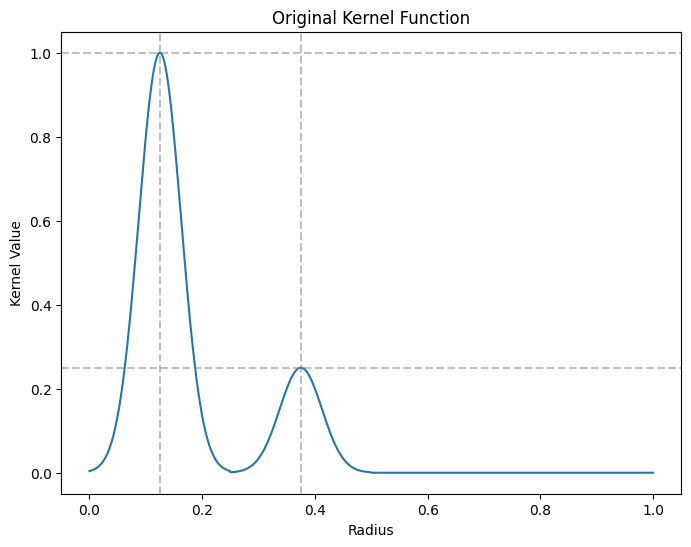

In [25]:
# Plot the original kernel function
kernel_index = 2
kernel_params = kernel_params_list[kernel_index]
# kernel_params = OriginalKernelParams(channel_source=2, channel_target=0, r=0.82, b=jnp.array([1/6, 1., 0.2]))
r = jnp.linspace(0.0, 1.0, 1000)
kernel_values = original_kernel_fn(r, kernel_params)

plt.figure(figsize=(8, 6))
plt.plot(r, kernel_values)

# Add horizontal lines for b values
for b in kernel_params.b:
	plt.axhline(y=b, color="gray", linestyle="--", alpha=0.5)

# Add vertical lines at peaks (segment boundaries)
number_of_segments = jnp.count_nonzero(~jnp.isnan(kernel_params.b), axis=-1)
for i in range(number_of_segments):
	peak_x = (i + 0.5) * kernel_params.r / number_of_segments
	plt.axvline(x=peak_x, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Radius")
plt.ylabel("Kernel Value")
plt.title("Original Kernel Function")
plt.show()

### Free kernel function

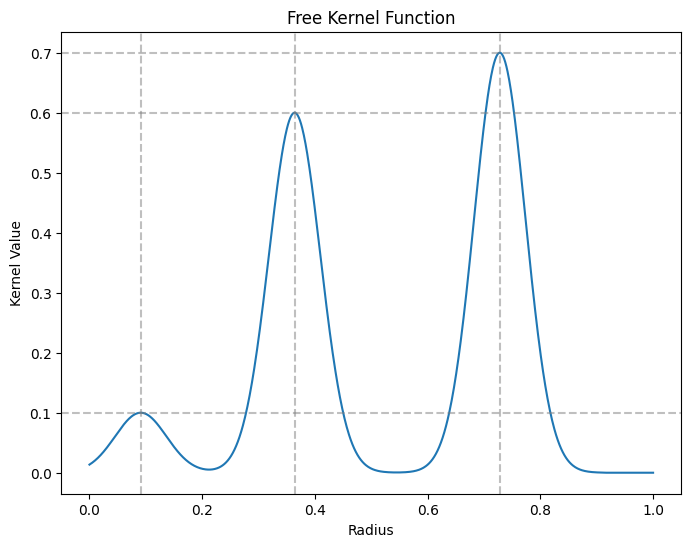

In [27]:
kernel_params = FreeKernelParams(
	r=0.91,
	b=jnp.array([0.1, 0.6, 0.7]),
	a=jnp.array([0.1, 0.4, 0.8]),
	w=jnp.array([0.05, 0.05, 0.05]),
)

# Plot the free kernel function
r = jnp.linspace(0.0, 1.0, 1000)
kernel_values = jax.vmap(free_kernel_fn, in_axes=(0, None))(r, kernel_params)

plt.figure(figsize=(8, 6))
plt.plot(r, kernel_values)

# Add horizontal lines for b values
for b in kernel_params.b:
	plt.axhline(y=b, color="gray", linestyle="--", alpha=0.5)

# Add vertical lines at peak positions
for a in kernel_params.a:
	plt.axvline(x=a * kernel_params.r, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Radius")
plt.ylabel("Kernel Value")
plt.title("Free Kernel Function")
plt.show()

In [293]:
kernel_params = FreeKernelParams(
	r=0.91,
	b=jnp.array([0.1, 0.6, 0.7]),
	a=jnp.array([0.1, 0.4, 0.8]),
	w=jnp.array([0.05, 0.05, 0.05]),
)

In [425]:
def sample_kernel_params(key: jax.Array, k: int = 3):
	key_r, key_b, key_a, key_w = jax.random.split(key, 4)
	r = jax.random.uniform(key_r, minval=0.9, maxval=1.0)
	b = jax.random.uniform(key_b, shape=(k,), minval=0.0, maxval=1.0)
	a = jax.random.uniform(key_a, shape=(k,), minval=0.0, maxval=1.0)
	w = jax.random.uniform(key_w, shape=(k,), minval=0.05, maxval=0.05)
	return FreeKernelParams(r=r, b=b, a=a, w=w)


key, subkey = jax.random.split(key)
kernel_params = sample_kernel_params(subkey)
kernel_params

FreeKernelParams(r=Array(0.95788324, dtype=float32), b=Array([0.09083593, 0.362208  , 0.62160695], dtype=float32), a=Array([0.7516383 , 0.7901324 , 0.17757165], dtype=float32), w=Array([0.05, 0.05, 0.05], dtype=float32))

In [426]:
def sample_growth_params(key: jax.Array):
	key_mean, key_std = jax.random.split(key)
	mean = jax.random.uniform(key_mean, minval=0.0, maxval=0.5)
	std = jax.random.uniform(key_std, minval=0.05, maxval=0.2)
	return GrowthParams(mean=mean, std=std)


sample_growth_params(key)

GrowthParams(mean=Array(0.14135998, dtype=float32), std=Array(0.06564356, dtype=float32))

In [430]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 15)

kernel_params_ = jax.vmap(sample_kernel_params)(keys)
growth_params_ = jax.vmap(sample_growth_params)(keys)

In [431]:
rule_params_all = rule_params_all.replace(
	kernel_params=kernel_params_, growth_params=growth_params_
)

In [432]:
rule_params_all

RuleParams(channel_source=Array([0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 2, 2],      dtype=int32, weak_type=True), channel_target=Array([0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 0, 1],      dtype=int32, weak_type=True), weight=Array([0.138, 0.48 , 0.284, 0.256, 0.5  , 0.622, 0.35 , 0.218, 0.556,
       0.344, 0.456, 0.67 , 0.42 , 0.43 , 0.278],      dtype=float32, weak_type=True), kernel_params=FreeKernelParams(r=Array([0.93349785, 0.9995953 , 0.9701198 , 0.9540144 , 0.96739423,
       0.93278384, 0.91701174, 0.9295168 , 0.96866286, 0.9051737 ,
       0.9340845 , 0.9543181 , 0.9992686 , 0.9496162 , 0.9432419 ],      dtype=float32), b=Array([[0.6465014 , 0.9202337 , 0.9478133 ],
       [0.44738257, 0.04953027, 0.97153664],
       [0.44446993, 0.73807013, 0.65684414],
       [0.15452015, 0.12305069, 0.43550003],
       [0.4936093 , 0.81509364, 0.98092186],
       [0.67104864, 0.49408925, 0.37623024],
       [0.48157084, 0.7293354 , 0.49027932],
       [0.5198953 , 0.22540629, 0.16742289],
 